#### Université Paul Sabatier, M2 MAPI3
# Machine learning - TP2

En tête pour charger les fonctions nécessaires au TP. La fonction <code>generateData</code> vous permet de générer autant d'échantillon que vous voulez du processus suivant:
- $X$ est uniforme sur $[-1,1]$
- $Y = \sin(5X) + \epsilon$ où $\epsilon$ est une gaussienne de moyenne $0$ et de variance $1/10$.

On commence avec un échantillon d'entrainement fixé que l'on dessine.

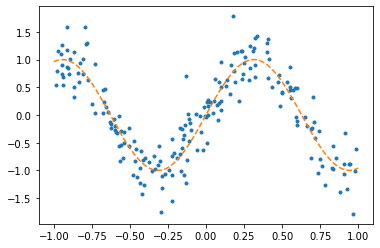

In [1]:
%matplotlib inline
from matplotlib import pyplot
import math
import numpy as np
import scipy.misc
import numpy.random as npr
import sklearn as sk
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import model_selection

def generateData(n,seed=2):
    npr.seed(seed)
    x = npr.rand(n)*2 - 1
    y = np.sin(x*5) + npr.normal(size=n) / np.sqrt(10)
    return(np.array(x).reshape(-1,1),np.array(y).reshape(-1,1))

n = 200
(xn,yn) = generateData(n)
xSeq = np.array(np.linspace(-1,1,2000)).reshape(-1,1)
pyplot.plot(xn,yn,'.')
pyplot.plot(xSeq,np.sin(xSeq * 5),'--')

**Question 1:** A quoi sert l'argument `seed` de la fonction `generateData`? Que se passe t'il si cet argument n'est pas spécifié? Quel est le nom de la courbe orange? Que vaut l'erreur de Bayes? Reproduisez le dessin ci-dessous avec un échantillon issu du même processus, mais indépendant du premier, `(xn, yn)`. Donner la commande vous permettant de simuler un échantillon de test, indépendant de l'échantillon d'entrainement `(xn, yn)`, et de taille `nTest=3000`.

- L'argument 'seed' est le paramètre qui permet d'initialiser le random number generator. S'il n'est pas spécifié, le tirage est aléatoire. S'il est spécifié, le tirage est aléatoire mais reproduit toujours la même séquence.

- La courbe orange est la sinusoïde qui correspond à un bruit nul sur les données.

- L'erreur de Bayes est celle qui correspond au meilleur classifier sur cette data

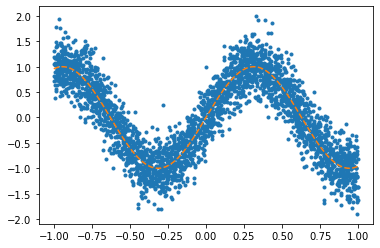

In [5]:
nTest = 3000
(xn_test,yn_test) = generateData(nTest, seed=42)
xSeq_test = np.array(np.linspace(-1,1,2000)).reshape(-1,1)
pyplot.plot(xn_test,yn_test,'.')
pyplot.plot(xSeq_test,np.sin(xSeq_test * 5),'--')

## Implémenter l'arbre de régression.

L'échantillon d'entrainement est fixé, de taille `n=200` par la commande `(xn,yn) = generateData(n)`. La commande suivante représente l'échantillon correspondant, ainsi que des arbres de régression [sk.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html), de profondeur maximale $2, 5, 10,15$.

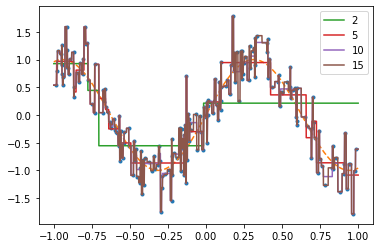

In [6]:
pyplot.plot(xn,yn,'.')
pyplot.plot(xSeq,np.sin(xSeq * 5),'--')
for k in (2,5,10,15):
    dtr = sk.tree.DecisionTreeRegressor(max_depth = k)
    dtr.fit(xn, yn)
    yPred = dtr.predict(xSeq)
    pyplot.plot(xSeq, yPred, label = k)

pyplot.legend()

**Question 2:** Commenter l'allure des graphiques ci-dessus. En quoi est ce que la profondeur maximale détermine la complexité du modèle? Que calcule la commande ci-dessous? A quoi sert le `reshape`? Que signifie cette valeur?

Les arbres capturent d'autant plus de points (et donc potentiellement de bruit) que la profondeur maximum est importante, et donc permet plus de branches et une granularité plus fine.

.predict va calculer les prédictions du modèle fitté aux points xn. Le reshape est nécessaire pour matcher la dimension du tableau yn. On calcule ici l'erreur quadratique moyenne (MSE).

Pour le dernier arbre, avec potentiellement 15 niveaux donc 2^15 feuilles, chaque point est isolé dans l'arbre : il y a overfitting et la MSE est nulle.

In [4]:
np.mean((yn - np.reshape(dtr.predict(xn), (n,1)))**2)

0.0

**Question 3:** représenter, en fonction de la profondeur maximale $p = 1, \ldots, 15$ l'erreur d'entrainement et une estimation de l'erreur de prédiction en fonction de $p$. Cette erreur de prédiction est évaluée sur un échantillon de test indépendant de taille `3000`. Commenter l'allure de cette courbe. Que vaut l'erreur de prédiction minimale et quelle est la valeur de $p$ correspondante? Nommer les régimes en dessous et au dessus de ces valeurs.


**Rappel:**, Pour estimer l'erreur d'entrainment il faut déterminer ce que le modèle prédit sur l'ensemble d'entrainement. Pour estimer l'erreur de prédiction, il faut déterminer ce que le modèle prédit sur un échantillon de test, qui doit indépendant de celui d'entrainement.

Min train error: 0.0
Min test error: 0.13894301453996374


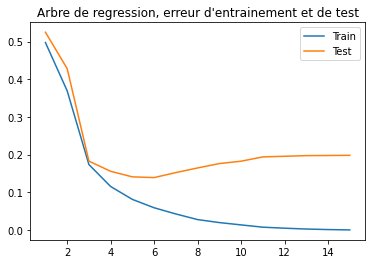

In [15]:
(xtest,ytest) = generateData(3000, 4)
maxP = 15
ps = np.arange(maxP) + 1
trainError = 1. * np.arange(maxP)
testError = 1. * np.arange(maxP)

for p in ps:
    #Modifier le code ici
    dtr = sk.tree.DecisionTreeRegressor(max_depth = p)
    dtr.fit(xn, yn)
    #yPred = dtr.predict(xtest)
    trainError[p-1]=np.mean((yn - np.reshape(dtr.predict(xn),(200,1)))**2)
    testError[p-1]=np.mean((ytest - np.reshape(dtr.predict(xtest),(3000,1)))**2)

pyplot.plot(ps, trainError, label = "Train")
pyplot.plot(ps, testError, label = "Test")
pyplot.title("Arbre de regression, erreur d'entrainement et de test")
pyplot.legend()    
print("Min train error: " + str(min(trainError)))
print("Min test error: " + str(min(testError)))

L'erreur de généralisation est minimale avec profondeur = 5 ou 6. Au delà, le modèle overfitte et la généralisation est mauvaise.

## Bagging regression trees.

On reprend la **Question 3** en utilisant le [bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html). Le régresseur de base reste un arbre.

**Question 4:** reprendre la question 3 en utilisant le bagging. A quoi sert le paramètre `n_estimators` du bagging? Représenter pour en fonction de la profondeur maximale $p = 1, \ldots, 15$ l'erreur d'entrainement et une estimation de l'erreur de prédiction en fonction de $p$. Commenter l'allure de cette courbe et comparer à la question précédente. Que vaut l'erreur de prédiction minimale? Comment cela se compare t'il à la question 3?


Min train error: 0.024569569268236904
Min test error: 0.11767901468853122


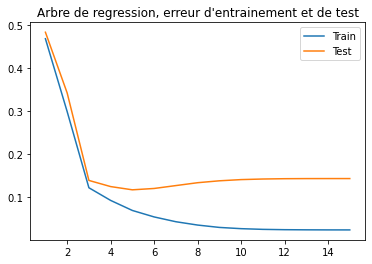

In [19]:
from sklearn.ensemble import BaggingRegressor

import warnings
warnings.filterwarnings('ignore')

(xtest,ytest) = generateData(3000, 4)
maxP = 15
ps = np.arange(maxP) + 1
trainError = 1. * np.arange(maxP)
testError = 1. * np.arange(maxP)

for p in ps:
    dtr = sk.tree.DecisionTreeRegressor(max_depth = p)
    bag_regr = BaggingRegressor(base_estimator=dtr,
                            n_estimators=100, 
                            random_state=0)
    bag_regr.fit(xn, yn)
    trainError[p-1]=np.mean((yn - np.reshape(bag_regr.predict(xn),(200,1)))**2)
    testError[p-1]=np.mean((ytest - np.reshape(bag_regr.predict(xtest),(3000,1)))**2)

pyplot.plot(ps, trainError, label = "Train")
pyplot.plot(ps, testError, label = "Test")
pyplot.title("Bagging DTR, erreur d'entrainement et de test")
pyplot.legend()    
print("Min train error: " + str(min(trainError)))
print("Min test error: " + str(min(testError)))

**Question 5:** A quoi sert le paramètre `n_estimators` du bagging? Que se passe t'il si vous modifiez ce paramètre? Illustrez cela avec des expériences.

n_estimators est le nombre de decision trees qui sont agrégés dans le modèle de bagging.

Plus ce nombre augmente, meilleur est le modèle.

**Question 6:** Remplacer les arbres de régression combinés au bagging par une [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor). Que remarquez vous par rapport à la question 4? Est ce surprenant? Formulez une récommendation pour le choix de la profondeur maximale dans les forêts alléatoires.

Min train error: 0.028885958139437045
Min test error: 0.12494716459081291


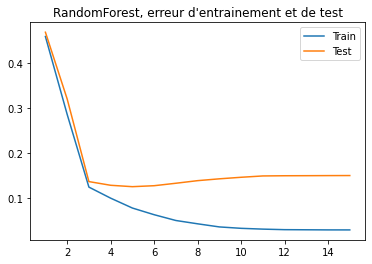

In [21]:
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

(xtest,ytest) = generateData(3000, 4)
maxP = 15
ps = np.arange(maxP) + 1
trainError = 1. * np.arange(maxP)
testError = 1. * np.arange(maxP)

for p in ps:
    randfor_regr = RandomForestRegressor(n_estimators=10,
                                         max_depth = p,
                                         random_state=0)
    randfor_regr.fit(xn, yn)
    trainError[p-1]=np.mean((yn - np.reshape(randfor_regr.predict(xn),(200,1)))**2)
    testError[p-1]=np.mean((ytest - np.reshape(randfor_regr.predict(xtest),(3000,1)))**2)

pyplot.plot(ps, trainError, label = "Train")
pyplot.plot(ps, testError, label = "Test")
pyplot.title("RandomForest, erreur d'entrainement et de test")
pyplot.legend()    
print("Min train error: " + str(min(trainError)))
print("Min test error: " + str(min(testError)))

Les courbes sont exactement les mêmes vs bagging, et pour cause : une random forest est par définition le bagging de decision trees.

On voir que l'erreur minimum de validation est atteinte pour une profondeur de 5.

## Boosting regression trees.

On reprend la **Question 3** et les suivantes en remplaçant le bagging par du le [boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor). Le régresseur de base reste un arbre.

**Question 7:** Représenter pour en fonction de la profondeur maximale $p = 1, \ldots, 15$ l'erreur d'entrainement et une estimation de l'erreur de prédiction en fonction de $p$. Commenter l'allure de cette courbe et comparer aux  questions précédentes. Que vaut l'erreur de prédiction minimale? Comment cela se compare t'il à la question 3 et aux suivantes? Quelle est la différence avec le bagging?

Min train error: 0.0017315714514950814
Min test error: 0.12393290043536748


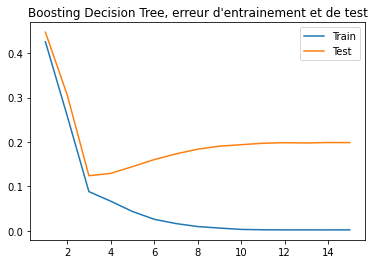

In [28]:
from sklearn.ensemble import AdaBoostRegressor

import warnings
warnings.filterwarnings('ignore')

(xtest,ytest) = generateData(3000, 4)
maxP = 15
ps = np.arange(maxP) + 1
trainError = 1. * np.arange(maxP)
testError = 1. * np.arange(maxP)

for p in ps:
    dtr = sk.tree.DecisionTreeRegressor(max_depth = p)
    boost_regr = AdaBoostRegressor(base_estimator = dtr,
                                   n_estimators=10,
                                   random_state=0)
    boost_regr.fit(xn, yn)
    trainError[p-1]=np.mean((yn - np.reshape(boost_regr.predict(xn),(200,1)))**2)
    testError[p-1]=np.mean((ytest - np.reshape(boost_regr.predict(xtest),(3000,1)))**2)

pyplot.plot(ps, trainError, label = "Train")
pyplot.plot(ps, testError, label = "Test")
pyplot.title("Boosting Decision Tree, erreur d'entrainement et de test")
pyplot.legend()    
print("Min train error: " + str(min(trainError)))
print("Min test error: " + str(min(testError)))

L'erreur de prédicition minimale est de l'ordre de 12% comme plus haut.
Le bagging aggrège plusieurs modèles (cad les prédictions de plusieurs modèles en paralèlle)
Le boosting améliore de façon itérative un modèle en travaillant sur les résidus.

**Question 8:** A quoi sert le paramètre `n_estimators` du boosting? Que se passe t'il si vous modifiez ce paramètre? Illustrez cela avec des expériences.

n_estimators est ici le nombre d'itérations maximal
Peu d'influence passés les 10 itérations

## Gradient boosting with regression trees.

L'échantillon d'entrainement est fixé. On reprend la question précédent en remplaçant le boosting par du le [gradient boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.GradientBoostingRegressor). Le régresseur de base reste un arbre (scikit-learn ne vous laisse pas le choix.

**Question 8:** Représenter pour en fonction de la profondeur maximale $p = 1, \ldots, 15$ l'erreur d'entrainement et une estimation de l'erreur de prédiction en fonction de $p$. Commenter l'allure de cette courbe. Que vaut l'erreur de prédiction minimale? Comparer avec ce que vous obtenez pour le bagging et le boosting?

Min train error: 4.39644796334144e-10
Min test error: 0.11629816267942003


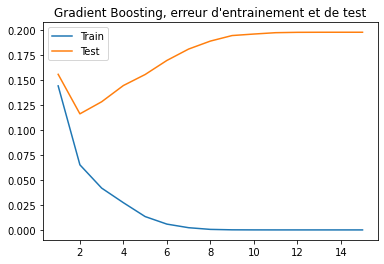

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

(xtest,ytest) = generateData(3000, 4)
maxP = 15
ps = np.arange(maxP) + 1
trainError = 1. * np.arange(maxP)
testError = 1. * np.arange(maxP)

for p in ps:
    gradboost_regr = GradientBoostingRegressor(n_estimators=100,
                                               max_depth = p,
                                               random_state=0)
    gradboost_regr.fit(xn, yn)
    trainError[p-1]=np.mean((yn - np.reshape(gradboost_regr.predict(xn),(200,1)))**2)
    testError[p-1]=np.mean((ytest - np.reshape(gradboost_regr.predict(xtest),(3000,1)))**2)

pyplot.plot(ps, trainError, label = "Train")
pyplot.plot(ps, testError, label = "Test")
pyplot.title("Gradient Boosting, erreur d'entrainement et de test")
pyplot.legend()    
print("Min train error: " + str(min(trainError)))
print("Min test error: " + str(min(testError)))

Estimer la variance par la méthode du bootstrap pour un échantillon d'entrainement fixé, comparer.

## Décomposition biais variance
Question difficile, ne la traiter qu'à la fin du TP. 

**Question 9:** que produit la commande suivante? Quel est le rôle de `1/3`? Pourquoi y a t'il un `reshape`?

In [31]:
dtr = sk.tree.DecisionTreeRegressor(max_depth = p+1)
dtr.fit(xn, yn)
dtr.predict(np.reshape(1/3,(1,-1)))

array([1.4311587])

Je viens calculer la prédiction en x=1/3 d'un modèle avec une profondeur supplémentaire (soit 16 ici)

**Question 10:** Vous savez que l'espérance conditionelle $\mathbb{E}[Y|X=x] = \sin(5x)$, pour tout $x$ et que l'erreur de Bayes est de $1/10$ (pourquoi?).  

L'erreur de Bayes est : $\mathbb{E}[(loss(Y(X),X)|X=x] = \mathbb{E}[(sin(5X)+\epsilon-sin(5X)^{2}|X=x] = \mathbb{E}(\epsilon)^{2)] = 1/10$

La taille de l'échantillon d'entrainement est fixée à `n=200`, vous pouvez générer autant d'échantillon que vous voulez. Expliquer en quoi la commande suivante estime la décomposition biais variance de l'erreur de prediction de l'estimateur de régression par arbre en $x = 1/3$ pour une profondeur maximale $p = 4$. 


**Rappel:** pour un estimateur $\hat{f}_n$ dépendant d'un échantillon $\left\{(X_i, Y_i)\right\}_{i=1}^n$, le biais et la variance sont donnés respectivement par:
$$\mathbb{E}_n\left[f^*(1/3) - \hat{f}_n(1/3) \right]^2 \qquad\qquad \text{Var}_n\left[ \hat{f}_n(1/3)\right]  $$
où $f^*(1/3) = \mathbb{E}[Y|X=1/3]$ désigne la règle de Bayes et $\mathbb{E}_n$ et $\text{Var}_n$ désignent l'espérance et la variance pour le tirage de l'échantillon.

Le code créé 100 fois un DTR de profondeur 4, qu'il entraine sur le jeu xn,yn de taille 200, et calcule la prédicition en x=1/3. Les prédictions sont stockées dans le tableau predUnTiers, qui permet de calculer le biais et la variance sur les deux dernières lignes, d'après les formules ci-dessus.

In [34]:
nTrain = 500
n=200
xPred = 1/3
predUnTiers = np.zeros(nTrain)
for i in range(nTrain):
    (xn,yn) = generateData(n,i)
    dtr = sk.tree.DecisionTreeRegressor(max_depth = 4)
    dtr.fit(xn, yn)
    predUnTiers[i] = dtr.predict(np.reshape(xPred,(1,-1)))

print("Biais: " + str(np.mean(predUnTiers- np.sin(5*xPred))**2 ) )
print("Variance: " + str(np.mean((predUnTiers - np.mean(predUnTiers))**2) ) ) 

Biais: 0.042099063975995686
Variance: 0.013829846874067296


**Question 11:** Vous savez que l'espérance conditionelle $\mathbb{E}[Y|X=x] = \sin(5x)$, pour tout $x$ et que l'erreur de Bayes est de $1/10$ (pourquoi?).  
La taille de l'échantillon d'entrainement est fixée à `n=200`, vous pouvez générer autant d'échantillon que vous voulez. Estimer et représenter la décomposition biais variance de l'erreur de prediction de l'estimateur de régression par arbre en $x = 1/3$ en fonction de la profondeur maximale $p$ variant entre 2 et 13. 

Min risque: 0.11487949441932863


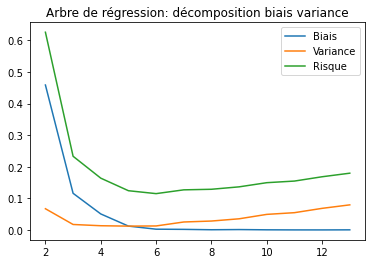

**Question 12:** Reprendre la question 9 avec le bagging puis avec le gradient boosting. Pour le gradient boosting, vous pouvez limiter la profondeur d'arbre à $p=1,\ldots, 6$. Comment pouvez vous décrire l'effet du bagging et du gradient boosting sur la variance et sur le biais. 

Min risque: 0.10983882705208499


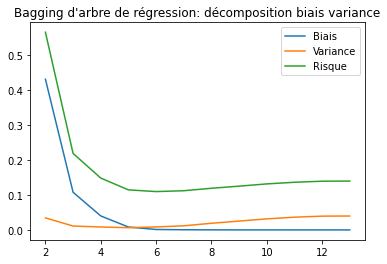

Min risque: 0.11560258855453596


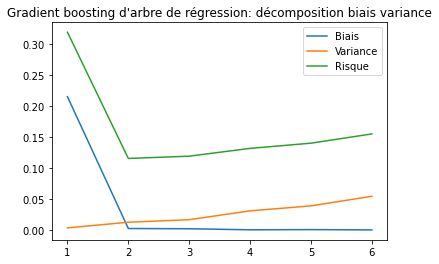

**Question 13:** Proposer une conclusion générale pour l'ensemble du TP.